In [1]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# **Step 1: Load the trained model**
model_path = './mood_prediction_model.pth'
if not os.path.exists(model_path):
    raise FileNotFoundError(f"{model_path} not found. Ensure the model is saved in the correct directory.")

In [3]:
# Define the model structure (must match the structure during training)
class MoodPredictorNN(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super(MoodPredictorNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, num_classes)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
# Load model parameters
input_size = 12  # Match the number of features used during training
num_classes = 4  # Number of unique mood labels in training data
loaded_model = MoodPredictorNN(input_size, num_classes)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()

C:\Users\tpete\AppData\Local\Temp\ipykernel_31640\174414349.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_path))


MoodPredictorNN(
  (fc1): Linear(in_features=12, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
  (relu): ReLU()
)

In [5]:
# **Step 2: Load and preprocess the metadata dataset**
metadata_path = './metadata_dataset.csv'
if not os.path.exists(metadata_path):
    raise FileNotFoundError(f"{metadata_path} not found. Ensure the file exists in the correct directory.")

metadata_df = pd.read_csv(metadata_path)

In [6]:
columns_to_keep = ['popularity', 'duration_ms', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 
                   'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
# Ensure only the features used during training are selected
metadata_features = metadata_df[columns_to_keep]

In [7]:
# **Step 3: Load the scaler and label encoder**
scaler_path = './scaler.pkl'
label_encoder_path = './label_encoder.pkl'
if not os.path.exists(scaler_path) or not os.path.exists(label_encoder_path):
    raise FileNotFoundError("Scaler or LabelEncoder file not found. Ensure they are saved correctly during training.")

scaler = joblib.load(scaler_path)
with open(label_encoder_path, 'rb') as f:
    label_encoder = pickle.load(f)

In [8]:
# Apply the scaler
metadata_features_scaled = scaler.transform(metadata_features)

In [9]:
# Convert to PyTorch tensor
metadata_tensor = torch.tensor(metadata_features_scaled, dtype=torch.float32)

In [10]:
# **Step 4: Predict Moods**
with torch.no_grad():
    outputs = loaded_model(metadata_tensor)
    _, predicted_moods = torch.max(outputs, 1)

In [11]:
# Add predicted moods to the metadata dataframe
metadata_df['predicted_mood'] = label_encoder.inverse_transform(predicted_moods.numpy())

In [12]:
# Evaluate model accuracy if true labels are present
if 'mood_encoded' in metadata_df.columns:
    y_true = metadata_df['mood_encoded']
    y_pred = predicted_moods.numpy()
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

In [13]:
# Confusion Matrix
if 'mood_encoded' in metadata_df.columns:
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [14]:
# **Step 5: Feature Visualization**
# Load the features dataset
features_df = pd.read_csv('features_dataset.csv')

# Assign moods based on valence and energy if not present in the features dataset
def assign_mood(row):
    if row['valence'] > 0.6 and row['energy'] > 0.7:
        return 'energetic'
    elif row['valence'] < 0.4 and row['energy'] < 0.5:
        return 'sad'
    elif row['valence'] > 0.6:
        return 'happy'
    else:
        return 'calm'

if 'mood' not in features_df.columns:
    features_df['mood'] = features_df.apply(assign_mood, axis=1)

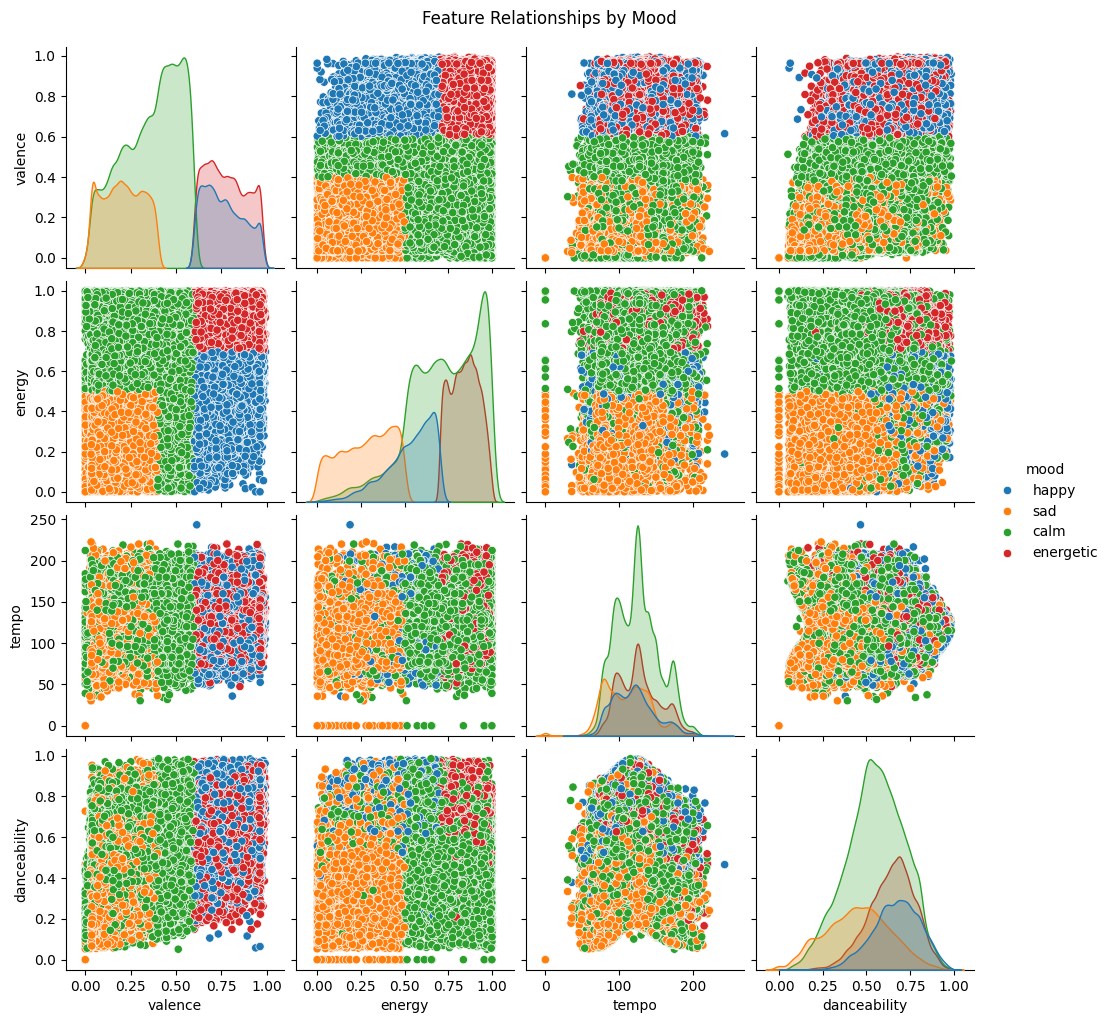

In [15]:
# Pairplot of key features
sns.pairplot(features_df, vars=['valence', 'energy', 'tempo', 'danceability'], hue='mood', diag_kind="kde")
plt.suptitle('Feature Relationships by Mood', y=1.02)
plt.show()

In [16]:
# **Step 6: Output playlists to the terminal**
for mood in metadata_df['predicted_mood'].unique():
    print(f"\nPlaylist for mood: {mood}")
    print(metadata_df[metadata_df['predicted_mood'] == mood][['track_name', 'artists', 'album_name']])


Playlist for mood: happy
                  track_name                    artists  \
0                     Comedy                Gen Hoshino   
5       Days I Will Remember               Tyrone Wells   
7                  I'm Yours                 Jason Mraz   
8                      Lucky  Jason Mraz;Colbie Caillat   
12                      Solo                   Dan Berk   
...                      ...                        ...   
113867            Petit pays              Cesária Evora   
113942         Beijo Roubado              Cesária Evora   
113946            Petit Pays              Cesária Evora   
113997        Miss Perfumado              Cesária Evora   
113999             Barbincor              Cesária Evora   

                                 album_name  
0                                    Comedy  
5                      Days I Will Remember  
7       We Sing. We Dance. We Steal Things.  
8       We Sing. We Dance. We Steal Things.  
12                                 

In [17]:
# Function to generate and return a playlist
def generate_user_playlist():
    # Get the list of unique moods
    moods = metadata_df['predicted_mood'].unique()

    # Display mood options
    print("Select a mood:")
    for idx, mood in enumerate(moods, 1):
        print(f"{idx}. {mood}")

    # Prompt user to select a mood
    while True:
        try:
            user_choice = int(input("\nEnter the number corresponding to your mood choice: "))
            if 1 <= user_choice <= len(moods):
                selected_mood = moods[user_choice - 1]
                break
            else:
                print("Invalid choice. Please select a valid number.")
        except ValueError:
            print("Please enter a valid number.")

    # Filter songs based on the selected mood
    mood_playlist = metadata_df[metadata_df['predicted_mood'] == selected_mood]

    # Randomly select 10 songs from the mood category selected
    num_songs = min(10, len(mood_playlist))
    selected_songs = mood_playlist.sample(n=num_songs)

    # Display the playlist with relevant columns
    print(f"\nPlaylist for mood: {selected_mood}")
    for _, row in selected_songs.iterrows(): 
        print(f"{row['track_name']} By: {row['artists']} Album: '{row['album_name']}'")

    # Returns playlist as df for future use
    return selected_songs[['track_name', 'artists', 'album_name']]

# Call the function to generate a playlist
playlist_info = generate_user_playlist()

Select a mood:
1. happy
2. sad
3. calm
4. energetic

Playlist for mood: happy
Espejo By: Nonpalidece Album: 'Nuevo Día'
Just a Crush By: The Pine Box Boys Album: 'Arkansas Killing Time'
street light By: Pete Bernhard Album: 'Things I Left Behind'
It's Very Sunny By: Casino Versus Japan Album: 'Back To Mine: Tycho'
Grazing In The Grass By: Hugh Masekela Album: '60's Gold'
O Amor Já Se Mudou Pra Cá By: MAR ABERTO;Vitor Kley Album: 'O Amor Já Se Mudou Pra Cá'
Tera Fitoor By: Arijit Singh Album: 'Genius (Original Motion Picture Soundtrack)'
Para Com Esse Papo - Ao Vivo By: Akatu;Grupo Revelação Album: 'Encontro de Gerações, Vol. 01 (Ao Vivo)'
Vem Morena By: Luiz Gonzaga Album: 'Olha Pro Céu'
Polaroid Love By: ENHYPEN Album: 'DIMENSION : ANSWER'


In [ ]:
# Sad
playlist_info = generate_user_playlist()

Select a mood:
1. happy
2. sad
3. calm
4. energetic

Playlist for mood: sad
Brown Noise Waves By: Loopable Album: 'Loopable Ambience of Brown Noise and Brown Waves'
TOMA By: Kelman Duran Album: 'TOMA'
Fever By: Joachim Pastor;Mischa Album: 'Fever'
A Quiet Triumph By: Jean DeVoite Album: 'A Quiet Triumph'
Notte senza fine - Kiasmos Remix By: Tale Of Us;Kiasmos Album: 'Endless (Remixes)'
Bird of Paradise By: Snowy White Album: 'Bird of Paradise - An Anthology'
Losar By: Joep Beving Album: 'Losar'
Bright Morning Star By: Ralph Stanley Album: 'Cry From The Cross'
Bubbles - Radio Mix By: Mpirgkel Album: 'Bubbles (Radio Mix)'
P E A C E - Acoustic By: Hillsong Young & Free Album: 'lll (Studio Sessions)'


In [ ]:
# calm
playlist_info = generate_user_playlist()

Select a mood:
1. happy
2. sad
3. calm
4. energetic

Playlist for mood: calm
Sanvale Sundar Roop Manohar By: Bhimsen Joshi Album: 'Abhanga Vani'
No Me Cambiarán By: Ricardo Iorio Album: 'Atesorando los cielos'
Sealed With A Kiss By: Brian Hyland Album: 'Chronology'
Kalinka (DJ Edit) By: The Darkraver Album: 'Kalinka (DJ Edit)'
Her Şeyi Yak By: Duman Album: 'Viral Şarkılar'
Besteste Band By: Swiss & Die Andern Album: 'Besteste Band'
Nuestra Canción By: Feid Album: 'Perreo Tenebroso Vol. 4'
Lumartes (Extended) By: Seth Troxler Album: 'Monday Dreamin''
Souls Without Maps By: Joseph Huber Album: 'The Suffering Stage'
Close Your Eyes By: Wilkinson;iiola Album: 'Cognition'


In [ ]:
# energetic
playlist_info = generate_user_playlist()

Select a mood:
1. happy
2. sad
3. calm
4. energetic

Playlist for mood: energetic
I Love to Love By: Tina Charles Album: 'I Love To Love - The Best Of'
Said Goodbye By: Knoxa;Jordan Shaw Album: 'Said Goodbye'
Run Rudolph Run By: Chuck Berry Album: 'Best Christmas Songs 2022 | For under the Mistletoe'
Dancing On The Ceiling By: Lionel Richie Album: '80s Bangers Vol. 2'
Dale Hasta Abajo By: Chris Jedi;Joey Montana Album: 'Hora del taco sin auto'
Ojah Awake By: Osibisa Album: 'Ojah Awake'
Big Daddy Wiz By: Wiz Khalifa;Girl Talk Album: 'Tic Tac - Just Rap'
シスター By: PornoGraffitti Album: 'THUMPΧ'
Bloco Resenha: Tá Vendo Aquela Lua / Que Situação / Valeu / Derê / Livre pra Voar / Brilho de Cristal / Deixa Acontecer / Vergonha na Cara / Tchau e Bença - Ao Vivo By: Kamisa 10 Album: 'Bloco Resenha: Tá Vendo Aquela Lua / Que Situação / Valeu / Derê / Livre pra Voar / Brilho de Cristal / Deixa Acontecer / Vergonha na Cara / Tchau e Bença (Ao Vivo)'
My Love By: Crocodylus Album: 'My Love'
